In [71]:
# !pip3 install opencv-python
# !pip install pillow


# Data: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/data
#Example Code: https://www.kaggle.com/code/vivekreddyloka/brain-tumor-classification-using-cnn


In [72]:
# Run these two blocks to load important libraries and set things up
import torch
from torch import nn
import numpy as np
import cv2
import os
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Lambda
from sklearn.preprocessing import LabelEncoder


In [73]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [74]:
class ImgDataset(Dataset):
    def __init__(self, images, labels):
        label_encoder = LabelEncoder()
        self.images = images
        self.labels = label_encoder.fit_transform(labels)
#         self.images = os.listdir(root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]
#         if self.transform:
#             image = self.transform(image)
#         return image

In [75]:
train_path = 'data/Training'
test_path = 'data/Testing'
labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
x_train = []
Y_train = []
x_test = []
Y_test = []

transform = transforms.Compose([
    ToTensor()
])

for label in labels:
    path = os.path.join(train_path,label)
    for file_name in os.listdir(path):
#         print(file_name)
        image = cv2.imread(os.path.join(path,file_name))
#         print(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (180, 180))
        pil_image = Image.fromarray(image)
        tensor_image = transform(pil_image)
        x_train.append(tensor_image)
        Y_train.append(label)
        
    path = os.path.join(test_path,label)
    for file_name in os.listdir(path):
        image = cv2.imread(os.path.join(path,file_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (180, 180))
        pil_image = Image.fromarray(image)
        tensor_image = transform(pil_image)
        x_test.append(tensor_image)
        Y_test.append(label)

train_set = ImgDataset(x_train, Y_train)
test_set = ImgDataset(x_test, Y_test)


In [76]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [79]:

class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.LazyLinear(4)
    
    def forward(self, x):
#         print(x)
        y = self.pool1(self.conv1(x))
        y = self.pool2(self.conv2(y))
        y = self.linear(self.flatten(self.relu(y)))
#         print(y)
        return y

In [81]:
# Initialize the model, loss function, and optimizer
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
#         print(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')



Epoch [1/10], Loss: 1.0205
Epoch [2/10], Loss: 0.4876
Epoch [3/10], Loss: 0.2621
Epoch [4/10], Loss: 0.1301
Epoch [5/10], Loss: 0.0830
Epoch [6/10], Loss: 0.0442
Epoch [7/10], Loss: 0.0237
Epoch [8/10], Loss: 0.0125
Epoch [9/10], Loss: 0.0053
Epoch [10/10], Loss: 0.0023


In [82]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {(correct/total)*100:.2f}%')

Accuracy on test set: 73.35%


In [84]:

class CNNModel2(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.5)
        self.linear = nn.LazyLinear(4)
    
    def forward(self, x):
#         print(x)
        y = self.pool1(self.conv1(x))
        y = self.pool2(self.conv2(y))
        y = self.linear(self.dropout(self.flatten(self.relu(y))))
        
#         print(y)
        return y

In [85]:
# Initialize the model, loss function, and optimizer
model = CNNModel2()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
#         print(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')



Epoch [1/10], Loss: 0.9545
Epoch [2/10], Loss: 0.5151
Epoch [3/10], Loss: 0.3856
Epoch [4/10], Loss: 0.3210
Epoch [5/10], Loss: 0.2414
Epoch [6/10], Loss: 0.2074
Epoch [7/10], Loss: 0.1831
Epoch [8/10], Loss: 0.1498
Epoch [9/10], Loss: 0.1405
Epoch [10/10], Loss: 0.1114


In [86]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {(correct/total)*100:.2f}%')

Accuracy on test set: 71.32%


In [98]:

class CNNModel3(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
#         self.dropout = nn.Dropout(p=0.5)
        self.linear = nn.LazyLinear(4)
    
    def forward(self, x):
#         print(x)
        y = self.pool1(self.bn1(self.conv1(x)))
        y = self.pool2(self.bn2(self.conv2(y)))
        y = self.linear(self.flatten(self.relu(y)))
        
#         print(y)
        return y

In [99]:
# Initialize the model, loss function, and optimizer
model = CNNModel3()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
#         print(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses.append(running_loss/len(train_loader))
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')



Epoch [1/10], Loss: 8.1451
Epoch [2/10], Loss: 2.0307
Epoch [3/10], Loss: 1.8081
Epoch [4/10], Loss: 1.0787
Epoch [5/10], Loss: 0.9704
Epoch [6/10], Loss: 0.4971
Epoch [7/10], Loss: 0.3548
Epoch [8/10], Loss: 0.3436
Epoch [9/10], Loss: 0.1484
Epoch [10/10], Loss: 0.3213


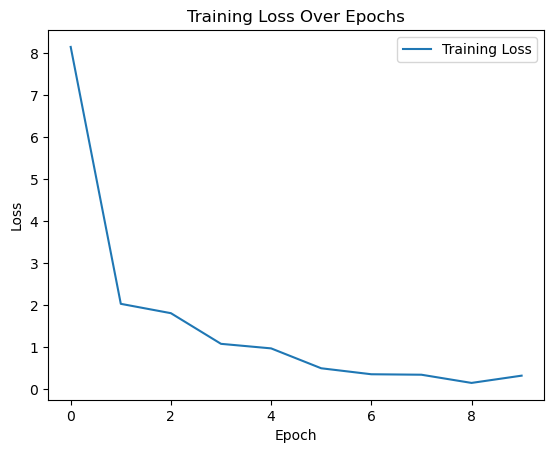

In [100]:
import matplotlib.pyplot as plt


# Plot the loss numbers
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [89]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {(correct/total)*100:.2f}%')

Accuracy on test set: 76.65%


In [90]:
test_path = 'experiment'
labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
x_train = []
Y_train = []
x_test = []
Y_test = []

transform = transforms.Compose([
    ToTensor()
])

for label in labels:
    path = os.path.join(test_path,label)
    for file_name in os.listdir(path):
        image = cv2.imread(os.path.join(path,file_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (180, 180))
        pil_image = Image.fromarray(image)
        tensor_image = transform(pil_image)
        x_test.append(tensor_image)
        Y_test.append(label)

test_set_child = ImgDataset(x_test, Y_test)
test_loader_child = DataLoader(test_set_child, batch_size=32, shuffle=False)

In [91]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader_child:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {(correct/total)*100:.2f}%')

Accuracy on test set: 42.86%


In [96]:

class CNNModel4(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.5)
        self.linear = nn.LazyLinear(4)
    
    def forward(self, x):
#         print(x)
        y = self.pool1(self.bn1(self.conv1(x)))
        y = self.pool2(self.bn2(self.conv2(y)))
        y = self.linear(self.dropout(self.flatten(self.relu(y))))
        
#         print(y)
        return y

In [97]:
# Initialize the model, loss function, and optimizer
model = CNNModel4()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
#         print(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')



Epoch [1/10], Loss: 6.2592
Epoch [2/10], Loss: 3.2436
Epoch [3/10], Loss: 1.8299
Epoch [4/10], Loss: 1.2958
Epoch [5/10], Loss: 1.3388
Epoch [6/10], Loss: 2.0282
Epoch [7/10], Loss: 1.0051


KeyboardInterrupt: 

In [ ]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {(correct/total)*100:.2f}%')